# Finite-Difference Simulation of Lid-Driven Cavity Flow
**(Final Assignment of Computational Physics 2025)**



## To Do
1. Calculate Pressure
2. Plot the fields at time [-1]
3. Check code with AI.

## General Infromation about Running the Code

- If the package `tqdm` is installed, you can set `system_evolution(..., show_progress=True)` to get a progress bar in the time evolution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

libertine_installed = True # Only set this to true if the font Linux Libertine is installed
tqdm_installed = True # Only set this to true if tqdm is installed

# Create data and figures folders if they do not exist
folder = "data"
if not os.path.exists(folder):
    os.mkdir(folder)

folder = "figures"
if not os.path.exists(folder):
    os.mkdir(folder)
    

Matplotlib style:

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

if libertine_installed: plt.rcParams.update({"font.serif": ["Linux Libertine"]})  # Same font as in LaTeX)

fsize_small = (4,2.75) # for a single colum in double colum
fsize_large = (6.5,4)

## Building the Functions

In [17]:
class LDC:
    def __init__(self,h,dt,Re,grid_size,vx_wall=1):
        self.h = h
        self.dt = dt 
        self.Re = Re
        self.grid_size = grid_size
        self.vx_wall = vx_wall
        self.initialize()
    # =====
    def initialize(self): # Careful, for changing grid_size you have to reassign the whole class
        self.N_y, self.N_x = self.grid_size # first y then x, so if we print it out it corresponds to the figure

    def update_stream_SOR(self, u, w, omega, max_iter, tol):
        '''
        '''

        for it in range(max_iter):
            max_r = 0.0
            for j in range(1, self.N_y-1):
                for i in range(1, self.N_x-1):
                    u_new = 0.25 * (u[j+1,i] + u[j-1,i] + u[j,i+1] + u[j,i-1] + self.h*self.h * w[j,i])
                    r = u_new - u[j,i]
                    u[j,i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol: break

        return u
    # =====
    def update_vorticity(self,u, w):

        w_new = np.copy(w)

        for j in range(1, self.N_y-1):
            for i in range(1, self.N_x-1):
                term1a = (u[j,i+1] - u[j,i-1]) * (w[j+1,i] - w[j-1,i]) 
                term1b = (u[j+1,i] - u[j-1,i]) * (w[j,i+1] - w[j,i-1])
                term2 = w[j,i+1] + w[j,i-1] + w[j+1,i] + w[j-1,i] - 4*w[j,i]

                w_new[j,i] = w[j,i] + self.dt/(self.h*self.h) * (0.25 * (term1a - term1b) + (1/self.Re) * (term2))
        
        return w_new
    # =====
    def test_stability(self):
        stability = self.dt/(self.Re*self.h*self.h)
        if stability > 0.25:
            print(f'Warning: Stability condition not met! value: {stability:.3f}')
        else:
            print(f'Stability criterion value: {stability:.3f}')

        return None
    # =====
    def system_evolution(self, 
                    n_t,
                    SOR_omega=1.7, 
                    get_pressure=False, 
                    SOR_max_iter=10000, 
                    SOR_tol=1e-5,
                    ):
        '''
        '''
        self.test_stability()

        # Initialize storage arrays and arrays at t=0
        u_history = np.zeros((n_t, self.N_y, self.N_x)) # u at t=0 is 0
        w_history = np.zeros((n_t, self.N_y, self.N_x))
        w_history[0,-1, :] = -2 * self.vx_wall / self.h  # Top wall vorticity at t=0 (u=0 everywhere)
                                                                        
        u = u_history[0]
        w = w_history[0]

        if get_pressure: 
            p_history = np.zeros((n_t, self.N_y, self.N_x))
            p = p_history[0]

        if tqdm_installed:
            for n in tqdm(range(1,n_t)):
                # Update stream function
                u = self.update_stream_SOR(u, w, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)

                # vorticity boundary conditions
                factor = 2/(self.h*self.h)
                w[-1, :] = - factor * u[-2,:] - (2/self.h) * self.vx_wall # Top wall (A)
                w[:, -1] = - factor * u[:,-2]             # Right wall (B)
                w[0, :] = - factor * u[1, :]            # Bottom wall (C)
                w[:, 0] = - factor * u[:, 1]            # Left wall (D)

                # Update vorticity
                w = self.update_vorticity(u, w)
                u_history[n] = u
                w_history[n] = w
                if get_pressure:
                    p = np.zeros((self.N_y, self.N_x))  # Placeholder for pressure calculation
                    p_history[n] = p

        else:                       
            for n in range(1,n_t):
                # Update stream function
                u = self.update_stream_SOR(u, w, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)

                # vorticity boundary conditions
                factor = 2/(self.h*self.h)
                w[-1, :] = - factor * u[-2,:] - (2/self.h) * self.vx_wall # Top wall (A)
                w[:, -1] = - factor * u[:,-2]             # Right wall (B)
                w[0, :] = - factor * u[1, :]            # Bottom wall (C)
                w[:, 0] = - factor * u[:, 1]            # Left wall (D)

                # Update vorticity
                w = self.update_vorticity(u, w)
                u_history[n] = u
                w_history[n] = w
                if get_pressure:
                    p = np.zeros((self.N_y, self.N_x))  # Placeholder for pressure calculation
                    p_history[n] = p

        if get_pressure:
            return u_history, w_history, p_history
        else:
            return u_history, w_history
    # =====
    def convert_to_velocity(self, u):
        v_x = np.zeros((self.N_y, self.N_x))
        v_y = np.zeros((self.N_y, self.N_x))

        for j in range(1, self.N_y-1):
            for i in range(1, self.N_x-1):
                v_x[j,i] = (u[j,i+1] - u[j,i-1])/(2*self.h)
                v_y[j,i] = -(u[j+1,i] - u[j-1,i])/(2*self.h)
        
        # Apply boundary conditions for velocity
        v_x[-1, :] = self.vx_wall # Top wall, rest is already correctly 0

        return v_x, v_y
    # =====       
    def get_vx_center(self, u_array):
        i = int(self.N_x/2)
        j = int(self.N_y/2)
        return (u_array[:,j,i+1] - u_array[:,j,i-1])/2*self.h      


In [15]:
test = np.array([1,2,3])
test[:] = 0.0
print(test)

[0 0 0]


Let's test the function for a small grid size and a low number of time steps:

Stability criterion value: 0.050


100%|██████████| 99/99 [00:00<00:00, 187.28it/s]


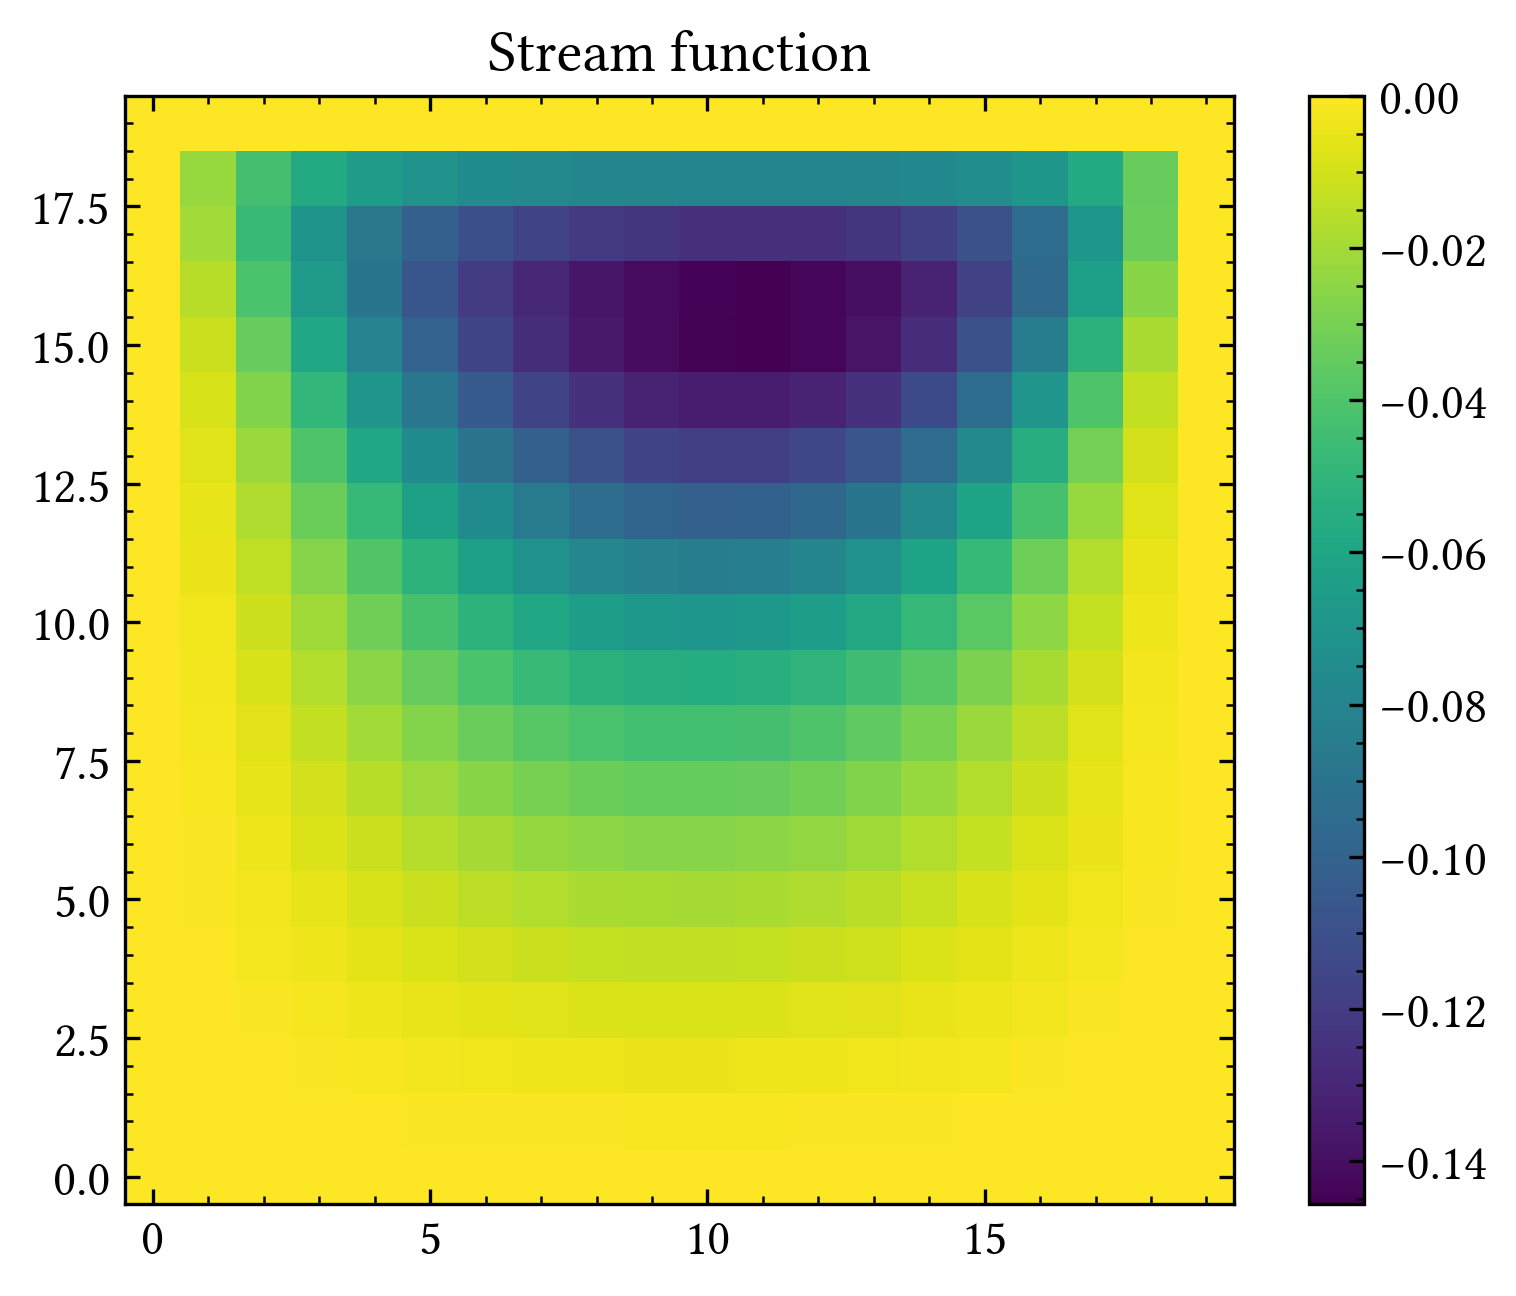

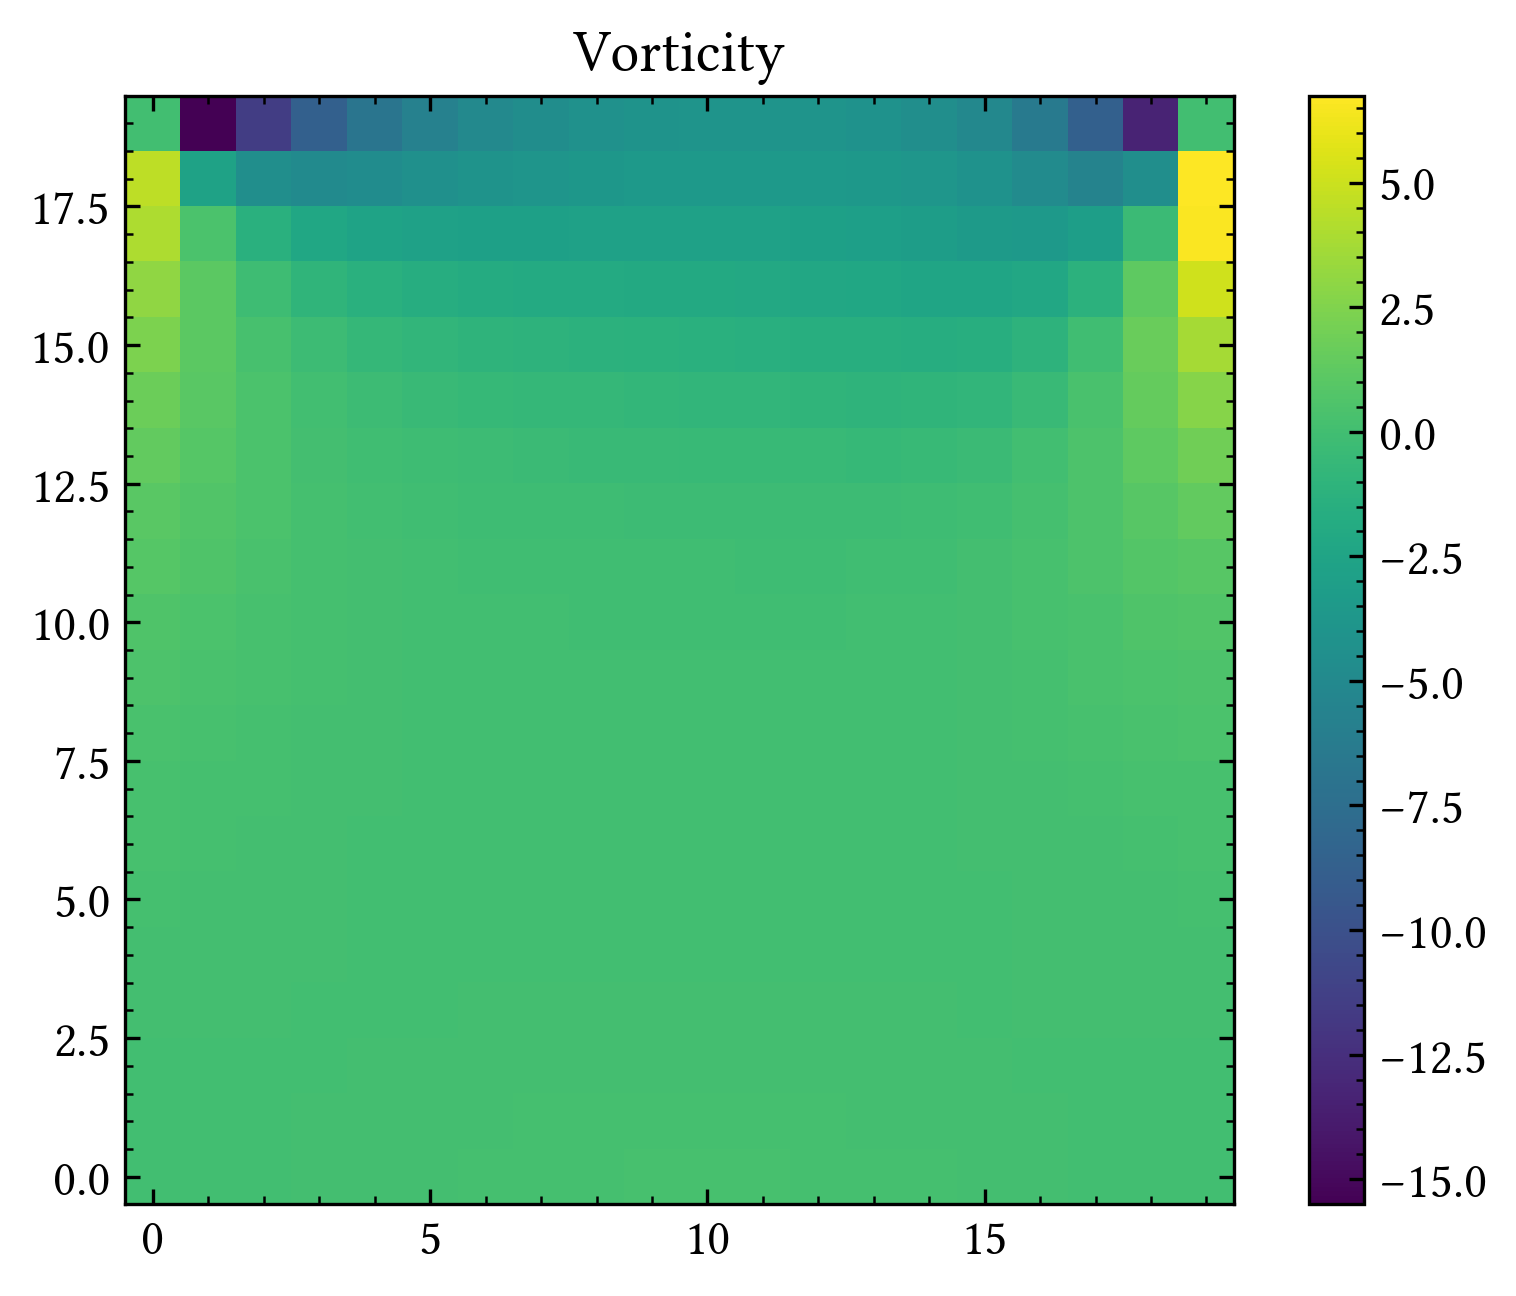

In [4]:
ldc_test = LDC(h=0.1, dt=0.01, Re=20, grid_size=(20,20),vx_wall=1)
u_test, w_test = ldc_test.system_evolution(n_t=100)

# u_test, w_test = system_evolution(h=0.1, dt=0.01, n_t=100, Re=20, grid_size=(20,20),vx_wall=1)

plt.imshow(u_test[-1], origin='lower'); plt.title("Stream function")
plt.colorbar()
plt.figure()
plt.imshow(w_test[-1], origin='lower'); plt.title("Vorticity")
plt.colorbar()

In [ ]:
n_t = 10000

print("Re=10")
ldc_10 = LDC(h=0.1,
             dt = 0.01,
             Re = 10,
             grid_size=(20,20),
             vx_wall=1
             )

u_10, w_10 = ldc_10.system_evolution(n_t=n_t)
np.save('data/ldc_Re10.npy', (u_10, w_10))

print("Re=100")
ldc_100 = LDC(h=0.1,
             dt = 0.01,
             Re = 100,
             grid_size=(20,20),
             vx_wall=1
             )

u_100, w_100 = ldc_100.system_evolution(n_t=n_t)
np.save('data/ldc_Re100.npy', (u_100, w_100))

print("Re=200")
ldc_200 = LDC(h=0.1,
             dt = 0.01,
             Re = 200,
             grid_size=(20,20),
             vx_wall=1
             )

u_200, w_200 = ldc_200.system_evolution(n_t=n_t)
np.save('data/ldc_Re200.npy', (u_200, w_200))

Stability criterion value: 0.100


100%|██████████| 9999/9999 [00:07<00:00, 1249.94it/s]


Stability criterion value: 0.010


100%|██████████| 9999/9999 [00:08<00:00, 1145.69it/s]


Stability criterion value: 0.005


100%|██████████| 9999/9999 [00:08<00:00, 1135.41it/s]


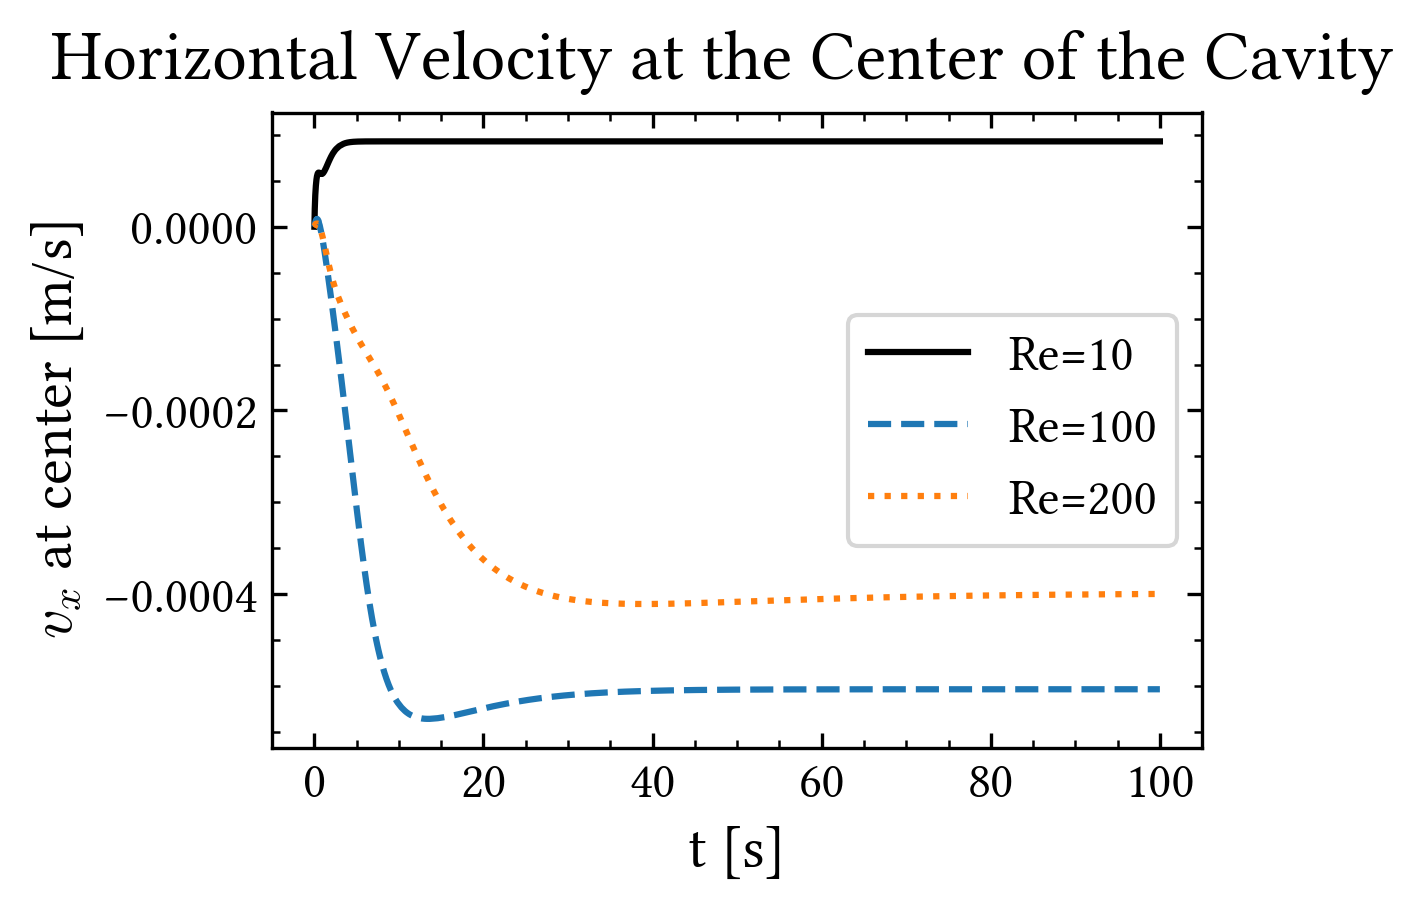

In [14]:
# plt.imshow(u_10[-1], origin='lower'); plt.title("Stream function")
# plt.colorbar()
# plt.figure()
# plt.imshow(w_10[-1], origin='lower'); plt.title("Vorticity")
# plt.colorbar()

vx_center_10 = ldc_10.get_vx_center(u_10)
vx_center_100 = ldc_100.get_vx_center(u_100)
vx_center_200 = ldc_200.get_vx_center(u_200)

t = np.arange(0,n_t)*ldc_10.dt

fig, ax = plt.subplots(figsize=fsize_small)
fig.suptitle("Horizontal Velocity at the Center of the Cavity")

ax.plot(t[1:], vx_center_10[1:], label='Re=10')
ax.plot(t[1:], vx_center_100[1:], label='Re=100', linestyle='--')
ax.plot(t[1:], vx_center_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t [s]")
ax.set_ylabel(r"$v_x$ at center [m/s]")
ax.legend()

plt.savefig('figures/vx_center.pdf')
plt.show()